In [1]:
import numpy as np
import os
import pandas as pds
import seaborn as sns
import matplotlib.pyplot as plt

# Auxiliar Functions #

In [2]:
def getData(policy, metric, wsize, scenario, arms, stop_criteria):
    expected_rewards = {'conversion_rate_two_arms': [0.05, 0.04], 
                        'navigation_time_two_arms': [0.15, 0.135],
                        'conversion_rate_many_arms': [0.05, 0.045, 0.04, 0.04, 0.035, 0.035, 0.03, 0.03, 0.02, 0.02], 
                        'navigation_time_many_arms': [0.15, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135]}
    
    if metric == 'regret_from_pulls':
        pulls_data = np.load('data/'  + policy + '-' + scenario + '_' + arms + '_' + 'wsize' + wsize + '_seed_1_low_traffic_nbPulls_' + stop_criteria + '.npy')
        rewards = np.array(expected_rewards[scenario + '_' + arms])
        rewards_diff = rewards[0] - rewards
        regrets_data = np.sum(pulls_data[:,1:]*rewards_diff[1:],1)
        return regrets_data
    else:
        data = np.load('data/'  + policy + '-' + scenario + '_' + arms + '_' + 'wsize' + wsize + '_seed_1_low_traffic_' + metric + '_' + stop_criteria + '.npy')
        return data

In [3]:
def get_table_summary(metric, scenario, arms, stop_criteria):
    regrets_scenario1_rem_value = pds.DataFrame(index=np.arange(500))
    policies = {'A/B test': ['TestAB_500', '0'],
                'PM_ws1': ['ProbabilityMatching_500', '1'],
                'PM_ws12': ['ProbabilityMatching_500', '12'],
                'e-Greedy': ['Egreedy_500', '1'],
                'TS': ['PossibilisticReward_chernoff2_500', '0']}
    
    if scenario == 'navigation_time':
        policies['PR2'] = policies.pop('TS')
        policies['PR3'] = ['PossibilisticReward_Bern1_500','0']
        
    for k,v in policies.iteritems():
        regrets_scenario1_rem_value[k] = pds.DataFrame(getData(v[0], metric, v[1], scenario, arms, stop_criteria))
    
    return regrets_scenario1_rem_value

In [4]:
def generate_latex_table(dataframe, round_digits):

    res_descripcion = dataframe.describe().round(round_digits).drop('count')
    res_descripcion_latex = res_descripcion.to_latex(encoding='utf-8')
    print(res_descripcion_latex)

In [5]:
def generate_graphics(dataframe, clasic):
    dataframe_desc = dataframe.describe()
    res_melted = pds.melt(dataframe, var_name='method', value_name='regret')
    num_policies = len(dataframe.columns)
    
    plt.figure(figsize=(12,12))
    sns.set_style("darkgrid")
    res_melted2 = res_melted.append(['PM wsize = 12', 0.0])
    res_melted2['huecol'] = -999
    res_melted2['huecol'].iloc[-1] = 0.0

    sns.set_palette(my_pal)
    sns.violinplot( x=res_melted2["regret"], 
                   y=res_melted2["method"], 
                   hue=res_melted2['huecol'], 
                   split=True, cut=0, 
                   linewidth=0.5, 
                   color='#F4A460',
                   inner='quartile')


    #plt.xlim(-2, clasic + 0.1*clasic)
    for i in range(num_policies):
        plt.plot((np.zeros(num_policies) + dataframe_desc.iloc[1, i]), np.linspace(i - 0.1 ,i , num_policies), color='red', linewidth=1, linestyle=":")

    best_policy = np.argmin([dataframe_desc.iloc[1, i] for i in range(num_policies)])
    plt.plot((np.zeros(num_policies) + dataframe_desc.iloc[1, best_policy]), np.linspace(-0.4 , num_policies - 0.75 , num_policies), color='violet', linewidth=2, linestyle=":")
    plt.plot((np.zeros(num_policies) + dataframe_desc.iloc[1, best_policy]), np.linspace(best_policy - 0.1 , best_policy, num_policies), color='red', linewidth=2)

    plt.plot((np.zeros(num_policies) + clasic), np.linspace(-0.4 , num_policies - 0.75 , num_policies), color='grey', linewidth=2, linestyle=":")
    plt.legend().remove()
    plt.annotate('best method: ' +  str(round(dataframe_desc.iloc[1, best_policy],2)), [dataframe_desc.iloc[2, best_policy] + 2.1, - 0.45], fontsize=14)
    plt.annotate('stand. test: ' +  str(round(clasic,2)), [clasic - 1.5, num_policies - 0.6], fontsize=14)
    sns.despine()
    plt.xlabel("Regret",fontsize=24)
    plt.ylabel('')
    plt.tick_params(labelsize=22)
    plt.savefig("output.png", bbox_inches = 'tight')    

In [6]:
def generate_table_and_graphic(metric, scenario, arms, stop_criteria, round_digits=3):
    regrets_sampling_beta = get_table_summary(metric, scenario, arms, stop_criteria)
    clasic = {'conversion_rate_two_arms_last_regrets': 47034*(0.05-0.045),
             'conversion_rate_many_arms_last_regrets': 70641*9*(0.05-0.045),
             'navigation_time_two_arms_last_regrets': 14114*(0.15-0.135),
             'navigation_time_many_arms_last_regrets': 21198*9*(0.15-0.135),
             'conversion_rate_two_arms_num_events': 47034,
             'conversion_rate_many_arms_num_events': 70641*10,
             'navigation_time_two_arms_num_events': 14114*2,
             'navigation_time_many_arms_num_events': 21198*10}
    
    f = lambda x: round(x,2)
    generate_latex_table(regrets_sampling_beta, round_digits)
    generate_graphics(regrets_sampling_beta, clasic[scenario + '_' + arms + '_' + metric]) 

In [7]:
def get_false_positives(scenario, arms, stop_criteria):
    
        frame = pds.DataFrame(index=np.arange(500))
        policies = {'A/B test': ['TestAB_500', '0'],
                    'PM_ws1': ['ProbabilityMatching_500', '1'],
                    'PM_ws12': ['ProbabilityMatching_500', '12'],
                    'e-Greedy': ['Egreedy_500', '1'],
                    'TS': ['PossibilisticReward_chernoff2_500', '0']}
    
        if scenario == 'navigation_time':
            policies['PR2'] = policies.pop('TS')
            policies['PR3'] = ['PossibilisticReward_Bern1_500','0']
                
        for k,v in policies.iteritems():
            means = np.load('data/'  + v[0] + '-' + scenario + '_' + arms + '_' + 'wsize' + v[1] + '_seed_1_low_traffic_last_means_' + stop_criteria + '.npy')
            true_pos = np.array([all([mean[0] >= i for i in mean]) for mean in means])
            frame[k] = pds.DataFrame(true_pos)

        
        desc= frame.describe()
        desc2 = desc.append(desc.iloc[0] - desc.iloc[3], ignore_index=True)
        desc3 = desc2.append(desc2.iloc[4]/desc2.iloc[0]*100, ignore_index=True)
        desc4 = desc3.drop([1, 2, 3])
        desc5 = desc4.rename({4: 'errors', 0: 'total', 5:'% errors'}, axis='index')
        return desc5

In [8]:
def sort_all_solutions(scenario, arms):
    criteria = ['sampling_beta', 'pr2']
    if scenario == 'navigation_time':
        criteria += ['sampling_beta_PR3', 'pr3']
    
    frame = get_table_summary('last_regrets', scenario, arms, criteria[0])
    frame_sum = frame.describe()
    
    frame_sum.columns = [name + "--" + criteria[0] for name in frame_sum.columns.values]
    frame_sum_transpose = frame_sum.transpose()
    stop_criteria_alias = {'sampling_beta_conversion_rate':'BerValRem',
                           'sampling_beta_navigation_time':'PR2 ValRem',
                           'sampling_beta_PR3_navigation_time':'PR3 ValRem',
                           'pr2_conversion_rate': 'PR2 bounds',
                           'pr2_navigation_time': 'PR2 bounds',
                           'pr3_navigation_time': 'PR3 bounds'}
    for c in criteria[1:]:
            f = get_table_summary('last_regrets', scenario, arms, c)
            f_sum = f.describe()
            f_sum.columns = [name + "--" + c for name in f_sum.columns.values]
            f_sum_transpose = f_sum.transpose()
            frame_sum_transpose = frame_sum_transpose.append(f_sum_transpose)
    
    stop_cr = [stop_criteria_alias[row.split('--')[1] + '_' + scenario] for row in frame_sum_transpose.index]
    frame_sum_transpose['stop criteria'] = stop_cr
    
    frame_sum_transpose.index = [row.split('--')[0] for row in frame_sum_transpose.index]
    return frame_sum_transpose.sort_values('mean')[['stop criteria','mean','std']]

In [9]:
def sort_all_by_num_events(scenario, arms):
    criteria = ['sampling_beta', 'pr2']
    if scenario == 'navigation_time':
        criteria += ['sampling_beta_PR3', 'pr3']
    
    frame = get_table_summary('num_events', scenario, arms, criteria[0])
    frame_sum = frame.describe()
    
    frame_sum.columns = [name + "--" + criteria[0] for name in frame_sum.columns.values]
    frame_sum_transpose = frame_sum.transpose()
    stop_criteria_alias = {'sampling_beta_conversion_rate':'BerValRem',
                           'sampling_beta_navigation_time':'PR2 ValRem',
                           'sampling_beta_PR3_navigation_time':'PR3 ValRem',
                           'pr2_conversion_rate': 'PR2 bounds',
                           'pr2_navigation_time': 'PR2 bounds',
                           'pr3_navigation_time': 'PR3 bounds'}
    for c in criteria[1:]:
            f = get_table_summary('num_events', scenario, arms, c)
            f_sum = f.describe()
            f_sum.columns = [name + "--" + c for name in f_sum.columns.values]
            f_sum_transpose = f_sum.transpose()
            frame_sum_transpose = frame_sum_transpose.append(f_sum_transpose)
    
    stop_cr = [stop_criteria_alias[row.split('--')[1] + '_' + scenario] for row in frame_sum_transpose.index]
    frame_sum_transpose['stop criteria'] = stop_cr
    
    frame_sum_transpose.index = [row.split('--')[0] for row in frame_sum_transpose.index]
    return frame_sum_transpose.sort_values('mean')[['stop criteria','mean','std']]

In [10]:
def sort_false_positives(scenario, arms):    
    criteria = ['sampling_beta', 'pr2']
    if scenario == 'navigation_time':
        criteria += ['sampling_beta_PR3', 'pr3']
    
    frame = get_false_positives(scenario, arms, criteria[0])
    frame_sum = frame
    
    frame_sum.columns = [name + "--" + criteria[0] for name in frame_sum.columns.values]
    frame_sum_transpose = frame_sum.transpose()
    stop_criteria_alias = {'sampling_beta_conversion_rate':'BerValRem',
                           'sampling_beta_navigation_time':'PR2 ValRem',
                           'sampling_beta_PR3_navigation_time':'PR3 ValRem',
                           'pr2_conversion_rate': 'PR2 bounds',
                           'pr2_navigation_time': 'PR2 bounds',
                           'pr3_navigation_time': 'PR3 bounds'}
    for c in criteria[1:]:
            f = get_false_positives(scenario, arms, c)
            f_sum = f
            f_sum.columns = [name + "--" + c for name in f_sum.columns.values]
            f_sum_transpose = f_sum.transpose()
            frame_sum_transpose = frame_sum_transpose.append(f_sum_transpose)
    
    stop_cr = [stop_criteria_alias[row.split('--')[1] + '_' + scenario] for row in frame_sum_transpose.index]
    frame_sum_transpose['stop criteria'] = stop_cr
    
    frame_sum_transpose.index = [row.split('--')[0] for row in frame_sum_transpose.index]
    return frame_sum_transpose

In [11]:
def show_graph_2(dataframe, clasic):
    num_policies = len(dataframe.columns)
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    dataframe_desc = dataframe.describe()
    res_melted = pds.melt(dataframe, var_name='method', value_name='regret')
    df = res_melted
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="method", hue="method", aspect=10, height=1.2, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "regret", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    g.map(sns.kdeplot, "regret", clip_on=False, color="w", lw=2, bw=.2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)
   
    

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-0.3, .2, label, fontweight="bold", color=color, fontsize=16,
            ha="left", va="center", transform=ax.transAxes)


    g.map(label, "regret")

    # Set the subplots to overlap
   
    
    best_policy = np.min([dataframe_desc.iloc[1, i] for i in range(num_policies)])
    #plt.plot((np.zeros(num_policies) + dataframe_desc.iloc[1, best_policy]), np.linspace(-0.4 , num_policies - 0.75 , num_policies), color='violet', linewidth=2, linestyle=":")
    #plt.plot((np.zeros(num_policies) + dataframe_desc.iloc[1, best_policy]), np.linspace(best_policy - 0.1 , best_policy, num_policies), color='red', linewidth=2)

    #plt.plot((np.zeros(num_policies) + clasic), np.linspace(-0.4 , num_policies - 0.75 , num_policies), color='grey', linewidth=2, linestyle=":")
    #plt.legend().remove()
    #plt.annotate('best method: ' +  str(round(dataframe_desc.iloc[1, best_policy],2)), [dataframe_desc.iloc[2, best_policy] + 2.1, - 0.45], fontsize=14)
    #plt.annotate('stand. test: ' +  str(round(clasic,2)), [clasic - 1.5, num_policies - 0.6], fontsize=14)
    
    
    # Remove axes details that don't play well with overlap

    g.map(plt.axvline, x=best_policy, lw=2, clip_on=False, color='r', linestyle='--')
    g.map(plt.axvline, x=clasic, lw=2, clip_on=False, color='b', linestyle='--')
    
    def vertical_mean_line_survived(x, **kwargs):
        plt.axvline(x.mean(), lw=2, linestyle = '--', color = 'black', ymax=0.3)
        
    def vertical_max_line_survived(x, **kwargs):
        #plt.axvline(x.max(), lw=2, linestyle = '-', color = 'red', ymax=0.2, ymin=-5)
        ax = plt.gca()
        ax.axvline(x.max(), lw=1.5, linestyle = ':', marker='d', fillstyle='full', color = 'blue', ymax=0.35)
        #ax.avspan(x.max() - 0.1, x.max() + 0.1, 0, 0.2, color = 'blue')
        plt.text(x.max(), plt.ylim()[1]/2, 'max', fontweight="bold", color='blue', fontsize=8,
            ha="center", va="center")
    
    g.map(vertical_mean_line_survived, 'regret')
    g.map(vertical_max_line_survived, 'regret')
    
    g.axes[0,0].annotate(round(best_policy, 2) , [best_policy + clasic/50 , plt.ylim()[1]/2])
    g.axes[-1,0].annotate(clasic, [clasic + clasic/50 , plt.ylim()[1]/2])
   
    g.fig.subplots_adjust(hspace=-.15)
    g.set_titles("")
    g.set(yticks=[])
    
    g.despine(bottom=True, left=True)
    plt.savefig("output.png", bbox_inches = 'tight')

In [12]:
def get_summary(scenario, arms, num):
    if num == 'all':
        data3 = sort_all_solutions(scenario, arms)
    else:   
        data3 = sort_all_solutions(scenario, arms).iloc[:num]
        #data2 = sort_all_solutions(scenario, arms).loc['Test AB'].iloc[0]
        #data3 = data1.append(data2)
        
    data4 = sort_all_by_num_events(scenario, arms)
    events = []

    for idx, row in data3.iterrows():
        temp = data4.loc[idx]
        criteria = row['stop criteria']
        events += [temp[temp['stop criteria'] == criteria]['mean'][0]]
    data3['num events mean'] = events
    
    data5 = sort_false_positives(scenario, arms)
    
    events = []
    for idx, row in data3.iterrows():
        temp = data5.loc[idx]
        criteria = row['stop criteria']
        events += [temp[temp['stop criteria'] == criteria]['% errors'][0]]
        
    data3['% errors'] = events
    data3 = data3.rename(columns={'mean': 'regret mean', 'std': 'regret std'})
    print(data3.to_latex(encoding='utf-8'))
    stop_criteria_alias = {'BerValRem': 'sampling_beta',
                           'PR2 ValRem': 'sampling_beta',
                           'PR3 ValRem': 'sampling_beta_PR3',
                           'PR2 bounds': 'pr2',
                           'PR3 bounds': 'pr3'}
                                    
    clasic = {'conversion_rate_two_arms_last_regrets': 47034*(0.05-0.045),
             'conversion_rate_many_arms_last_regrets': 70641*9*(0.05-0.045),
             'navigation_time_two_arms_last_regrets': 14114*(0.15-0.135),
             'navigation_time_many_arms_last_regrets': 21198*9*(0.15-0.135),
             'conversion_rate_two_arms_num_events': 47034,
             'conversion_rate_many_arms_num_events': 70641*10,
             'navigation_time_two_arms_num_events': 14114*2,
             'navigation_time_many_arms_num_events': 21198*10}
    
    detail_data = pds.DataFrame(index=np.arange(500))
    for idx, row in data3.iterrows():
        criteria = row['stop criteria']
        criteria_file = stop_criteria_alias[criteria]
        table = get_table_summary('last_regrets', scenario, arms, criteria_file)
        detail_data[idx + ' | ' + criteria] = table[idx]
        
    #generate_graphics(detail_data, clasic[scenario + '_' + arms + '_' + 'last_regrets'])
    show_graph_2(detail_data, clasic[scenario + '_' + arms + '_' + 'last_regrets'])

# scenario 1: conversation rate, two arms #

\begin{tabular}{llrrrr}
\toprule
{} & stop criteria &  regret mean &  regret std &  num events mean &  \% errors \\
\midrule
PM\_ws1  &     BerValRem &     10.49850 &   13.517863 &           3432.0 &       7.6 \\
TS      &     BerValRem &     11.48576 &   14.436883 &           3873.3 &       8.0 \\
PM\_ws12 &     BerValRem &     12.64696 &   14.628431 &           4262.7 &       4.8 \\
\bottomrule
\end{tabular}



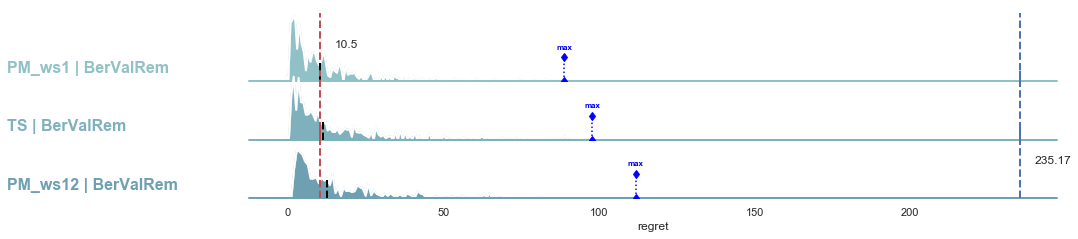

In [13]:
get_summary('conversion_rate', 'two_arms', 3)

# scenario 2: conversation rate, many arms #

\begin{tabular}{llrrrr}
\toprule
{} & stop criteria &  regret mean &  regret std &  num events mean &  \% errors \\
\midrule
PM\_ws1  &     BerValRem &    194.55531 &   74.035262 &         60639.18 &       0.0 \\
PM\_ws12 &     BerValRem &    194.78521 &   77.176648 &         61127.26 &       0.6 \\
TS      &     BerValRem &    197.54527 &   83.523536 &         63312.14 &       0.4 \\
\bottomrule
\end{tabular}



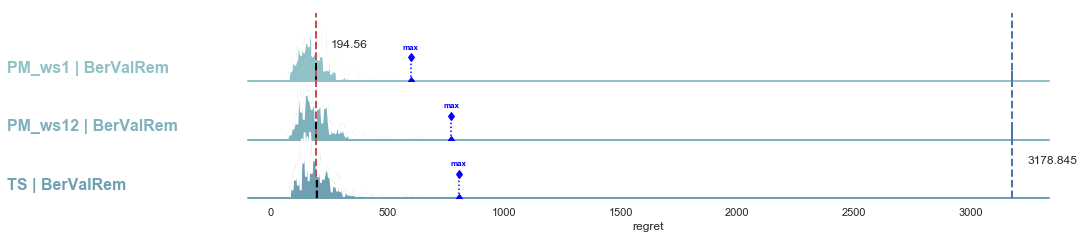

In [14]:
get_summary('conversion_rate', 'many_arms', 3)

# scenario 3: navigation time, two arms #

\begin{tabular}{llrrrr}
\toprule
{} & stop criteria &  regret mean &  regret std &  num events mean &  \% errors \\
\midrule
PR3    &    PR3 ValRem &    17.508818 &   16.160058 &           4769.7 &       1.2 \\
PM\_ws1 &    PR3 ValRem &    18.049706 &   16.999284 &           4259.9 &       1.6 \\
PR2    &    PR3 ValRem &    19.227081 &   17.658627 &           4502.2 &       1.0 \\
\bottomrule
\end{tabular}



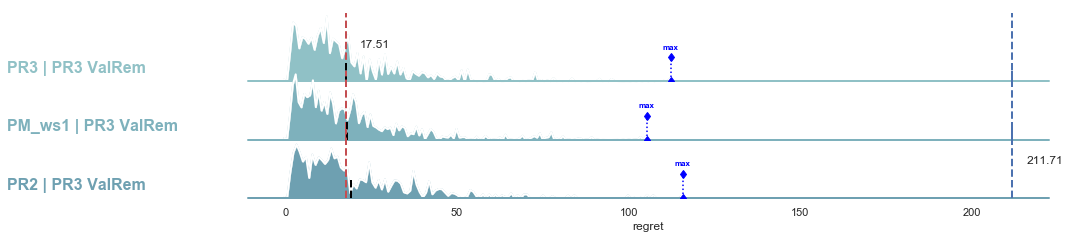

In [15]:
get_summary('navigation_time', 'two_arms', 3)

# scenario 4: navigation time, many arms #

\begin{tabular}{llrrrr}
\toprule
{} & stop criteria &  regret mean &  regret std &  num events mean &  \% errors \\
\midrule
PR3 &    PR3 bounds &   297.884755 &   72.733531 &         58374.62 &       0.0 \\
PR3 &    PR3 ValRem &   314.401856 &   65.791726 &         71610.50 &       0.0 \\
PR2 &    PR3 bounds &   331.952420 &   84.501561 &         47568.54 &       0.0 \\
\bottomrule
\end{tabular}



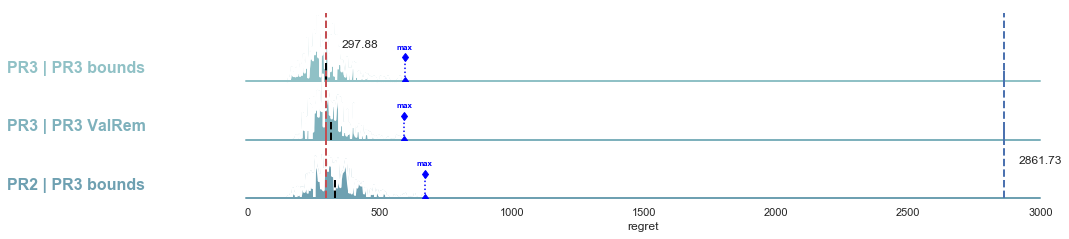

In [16]:
get_summary('navigation_time', 'many_arms', 3)

# scenario 1: conversation rate, two arms #